In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
#pd.core.common.is_list_like = pd.api.types.is_list_like
from SALib.sample import latin, fast_sampler
from SALib.analyze import fast
import json
import matplotlib.pyplot as plt
import init_objects
from functions.helpers import organise_data
from functions.sensitivity_an import simulate_params_efast
from model import *
from matplotlib import style
import scipy.stats as stats
import statsmodels.api as sm
import math

In [2]:
style.use('seaborn-ticks')

In [3]:
def confidence_interval(data, av):
    sample_stdev = np.std(data)
    sigma = sample_stdev/math.sqrt(len(data))
    return stats.t.interval(alpha = 0.95, df= 24, loc=av, scale=sigma) 

# Sensitivity analysis 
Using the eFast method.

Measure the influence of different parameters on gini, real gini, palma, real palma, profits, and volatility

In [4]:
problem = {
  'num_vars': 3,
  'names': ['std_noise', "w_random", "strat_share_chartists"],
  'bounds': [[0.03, 0.09], [0.02, 0.15], [0.02, 0.7]]
}

In [12]:
#param_values = fast_sampler.sample(problem, 65)
param_values = latin.sample(problem, N=25)
all_parameters = []
for parameters in param_values:
    pars = {}
    for key, value in zip(problem['names'], parameters):
        pars[key] = value
    all_parameters.append(pars)
    
fixed_parameters = {"trader_sample_size": 10,
          "n_traders": 1000,
          "init_stocks": 81,
          "ticks": 1000,
          "fundamental_value": 1129.8774292002786,
          "base_risk_aversion": 0.7,
          'spread_max': 0.004087,
          "horizon": 213,
          # Not modelled parameters
          "fundamentalist_horizon_multiplier": 1.0
         }

In [7]:
len(all_parameters)

2

In [9]:
gini_avs, real_gini_avs, palma_avs, real_palma_avs, av_profits, av_volatilities = simulate_params_efast(NRUNS=2, parameter_set=all_parameters, fixed_parameters=fixed_parameters)

Start of simulation  0
last mid-price was:  1143.3206615427998
Start of simulation  1
last mid-price was:  1188.7027135221283
Start of simulation  0
last mid-price was:  1122.328168893239
Start of simulation  1
last mid-price was:  1187.8236775576393


In [11]:
np.mean(real_gini_avs)

0.2379690079718806

In [9]:
confidence_interval(model_output, np.mean(model_output))

(-0.02304571513478808, -0.011696803748687059)

In [12]:
av_difference_BLR_SLR = np.array(model_output)

In [13]:
np.savetxt('av_differences.txt', av_difference_BLR_SLR, fmt='%d')

In [19]:
#excess_vol_BLR = pd.DataFrame(model_output, columns=['excess_vol_BLR'])

In [25]:
all_parameters[0]

{'std_noise': 0.06124061789129161,
 'w_random': 0.08768800543113182,
 'strat_share_chartists': 0.32199263961581887,
 'base_risk_aversion': 1.5859970463218376,
 'fundamentalist_horizon_multiplier': 3.0827078594194406,
 'mutation_intensity': 0.2843046341846871,
 'average_learning_ability': 0.42133480223533953}

In [47]:
std_noises = [all_parameters[idx]['std_noise'] for idx in range(len(all_parameters))]
w_randoms = [all_parameters[idx]['w_random'] for idx in range(len(all_parameters))]
share_chartists = [all_parameters[idx]['strat_share_chartists'] for idx in range(len(all_parameters))]
base_risk_aversions = [all_parameters[idx]['base_risk_aversion'] for idx in range(len(all_parameters))]
fundamentalist_horizon_multipliers = [all_parameters[idx]['fundamentalist_horizon_multiplier'] for idx in range(len(all_parameters))]
mutation_intensitys = [all_parameters[idx]['mutation_intensity'] for idx in range(len(all_parameters))]
average_learning_abilitys = [all_parameters[idx]['average_learning_ability'] for idx in range(len(all_parameters))]

In [48]:
excess_vol_BLR = pd.DataFrame(zip(model_output, std_noises, w_randoms, share_chartists, base_risk_aversions, fundamentalist_horizon_multipliers, mutation_intensitys, average_learning_abilitys), 
             columns=['excess_vol_BLR', 'std_noise', 'w_random', 'strat_share_chartists', 'base_risk_aversion', 'fundamentalist_horizon_multiplier', 'mutation_intensity', 'average_learning_ability'])

In [60]:
np.mean(excess_vol_BLR['excess_vol_BLR'])

8577985.067802997

## Scatterplots

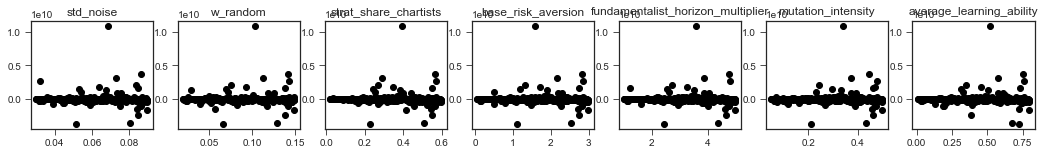

In [58]:
fig, axes = plt.subplots(1, 7, figsize=(18,2))



for i, name in enumerate(problem['names']):
    axes[i].plot(excess_vol_BLR[name], excess_vol_BLR['excess_vol_BLR'], 'o', color='black')
    axes[i].set_title(name)

In [ ]:
# do this for all moments and J-score
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 16))

N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.40       # the width of the bars

ax1 = axes[0,0] 
ax2 = axes[0,1]
ax3 = axes[0,2]
ax4 = axes[1,0]
ax5 = axes[1,1]
ax6 = axes[1,2]
ax7 = axes[2,0]
ax8 = axes[2,1]
ax9 = axes[2,2]
ax10 = axes[3,0]
ax11 = axes[3,1]

flat_axes = [item for sublist in axes for item in sublist]
output_labels = [label for label in sc_fast2.columns if label != 'share_mr']

for ax, label in zip(flat_axes, output_labels):
    ax.plot(sc_fast2['share_mr'], sc_fast2[label], 'o', color='black')
    #ax.set_title(label)
    ax.set_ylabel(label, fontsize='14')
    
axes[3, 2].remove()

# for ax in [ax1, ax4, ax7, ax10]:
#     ax.set_ylabel('Moment', fontsize='14')
    
for ax in flat_axes:
    ax.set_xlabel('$w^{mrf}$', fontsize='14')
    

plt.tight_layout()

fig.savefig('senstivity2_scatter.png', dpi=200)

In [ ]:
#b = np.loadtxt('test1.txt', dtype=int)

In [ ]:
impact_on_av_p = fast.analyze(problem, av_prices, print_to_console=False)
impact_on_stdev_p = fast.analyze(problem, stdev_prices, print_to_console=False)

In [ ]:
# plot 5 histograms 
#fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12,5))
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.40       # the width of the bars

ax1 = axes[0,0] 
ax2 = axes[0,1]
ax3 = axes[0,2]
ax4 = axes[1,0]
ax5 = axes[1,1]

ax1.set_title('No autocorrelation')
rects1 = ax1.bar(ind, impact_on_no_a['S1'], width, color='k')
rects2 = ax1.bar(ind + width, impact_on_no_a['ST'], width, color='w', hatch='\\')
#ax1.legend((rects1[0], rects2[0]), ('S1', 'ST'))
ax1.set_ylabel('impact')

ax2.set_title('Fat tails')
rects3 = ax2.bar(ind, impact_on_f_t['S1'], width, color='k')
rects4 = ax2.bar(ind + width, impact_on_f_t['ST'], width, color='w', hatch='\\')

ax3.set_title('Clustered volatility')
rects5 = ax3.bar(ind, impact_on_cv['S1'], width, color='k')
rects6 = ax3.bar(ind + width, impact_on_cv['ST'], width, color='w', hatch='\\')

ax4.set_title('Long memory')
rects7 = ax4.bar(ind, impact_on_lm['S1'], width, color='k')
rects8 = ax4.bar(ind + width, impact_on_lm['ST'], width, color='w', hatch='\\')
ax4.set_ylabel('impact')

ax5.set_title('Fundamental deviation')
rects9 = ax5.bar(ind, impact_on_df['S1'], width, color='k')
rects10 = ax5.bar(ind + width, impact_on_df['ST'], width, color='w', hatch='\\')
ax5.legend((rects9[0], rects10[0]), ('First-order sensitivity', 'Total sensitivity'), 
           loc='center left', bbox_to_anchor=(1.25, 0.5))

axes[1, 2].remove()

for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('F', 'MM', 'NS', 'MR'))
    ax.set_ylim(0, 1.0)
    
#fig.savefig('eFastExpectations.png')